# Мастерская 2 (DS20+). Решение задачи мэтчинга для "склада товаров"

Входные данные:
- `base.csv` - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- `target.csv` - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …), вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).
- `validation.csv` - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv
- `validation_answer.csv` - правильные ответы к предыдущему файлу.


Задачи:
- разработать алгоритм, который для всех товаров из `validation.csv` предложит несколько вариантов наиболее похожих товаров из `base`

- оценить качество алгоритма по метрике **accuracy@5**

- *деплой: разработать REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.

Основная задача матчинга будет решаться алгоритмом приближённого поиска ближайших соседей с помощью библиотеки `FAISS`.

## Подготовка среды

### Импорт библиотек

In [1]:
!pip install faiss-cpu

In [2]:
import pandas as pd
import numpy as np
import faiss
# from tqdm.notebook import tqdm
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

In [3]:
# библиотеки, необходимые для загрузки из облака архива с данными
# и его распаковки в текущую файловую систему
import zipfile
import requests
from urllib.parse import urlencode
import os.path

In [4]:
pip install catboost

In [5]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from catboost import cv, Pool
from sklearn.metrics import roc_auc_score, roc_curve
from joblib import dump, load
import matplotlib.pyplot as plt

### Загрузка данных из облака

Загрузим архив с данными из облака yandex.drive и распакуем файлы на виртуальный диск Colab

In [6]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'
zip_path = '/content/drive/MyDrive/data.zip'
#zip_path = '/content/data.zip'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [7]:
if not os.path.exists(zip_path):
  download_response = requests.get(download_url)
  with open(zip_path, 'wb') as f:
    f.write(download_response.content)

In [8]:
# Распаковка zip-архива
if not os.path.exists('/content/base.csv'):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

### Чтение датасетов

Подготовим словарь для корректной загрузки типов данных. По умолчанию загружается float64, мы используем float32.

In [9]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'

dict_train = dict_base.copy()
dict_train['Target'] = 'str'

Загрузка основного датасета `base.csv`

In [10]:
df_base = pd.read_csv("/content/base.csv", index_col=0, dtype=dict_base)
df_base.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
284530-base,-79.616257,-0.450382,77.687073,-158.627823,136.897461,-107.410217,-224.696381,97.063560,137.126236,154.108337,...,-82.157806,24.438972,-165.631104,122.627609,68.991364,0.970984,46.590046,119.468765,-1074.464844,-133.674255
2319113-base,-56.560768,15.642746,-57.586929,-119.791550,108.444847,-130.147903,-759.626038,31.498629,126.343117,187.631714,...,-116.798920,14.712795,-141.073532,-137.183945,69.775711,-39.610870,-2.749245,138.141296,-998.319824,-58.718086
2311030-base,-100.692444,11.026220,1.049137,-170.453140,193.436707,-63.800365,-207.028671,3.003248,129.651062,183.088120,...,-88.253075,48.478619,-106.724823,-59.119354,70.663139,46.492470,47.921036,97.982880,-511.342438,-91.318886
231970-base,-77.699585,7.839599,50.463646,-123.651947,51.148983,-50.896927,-759.626038,-20.151285,123.066475,116.143005,...,-2.184578,76.346634,-134.710022,-134.441010,64.566513,-55.968403,3.494137,126.438042,-395.255432,-74.235992
3531602-base,-53.069176,7.658435,-117.526321,-124.371025,124.765793,-55.893261,-606.931335,12.045328,126.421913,219.864365,...,-99.893074,25.126053,-147.254929,-76.936104,68.461273,40.856461,25.486137,102.071037,-1074.464844,-45.365246


In [11]:
df_base.shape

(2918139, 72)

In [12]:
df_base[['0','32','71']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   32      float32
 2   71      float32
dtypes: float32(3)
memory usage: 55.7+ MB


Загрузка датасета с таргетами `train.csv`

In [13]:
df_train = pd.read_csv("/content/train.csv", index_col=0, dtype=dict_train)
df_train.sample()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
54009-query,-44.456882,6.417444,-40.913433,-154.034683,70.546387,-90.28389,-376.754517,25.10906,127.79599,74.979073,...,33.727509,-202.535889,0.22846,68.464668,48.002937,71.623383,126.543015,-1074.464844,-42.848087,2669165-base


In [14]:
df_train.shape

(100000, 73)

Загрузка датасета с заданием `validation.csv`

In [15]:
df_validation = pd.read_csv("/content/validation.csv", index_col=0, dtype=dict_train)
df_validation.sample()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
145896-query,-56.365593,5.259336,33.474525,-153.865021,78.89357,-88.697205,-759.626038,47.095947,116.125175,28.020721,...,-77.686729,18.580898,-182.334839,-77.497543,64.543388,75.433098,115.510414,140.857346,-407.019379,-37.315666


In [16]:
#df_validation.iloc[0, :].tolist()

In [17]:
df_validation.shape

(100000, 72)

Загрузка датасета с ответами `validation_answer.csv`

In [18]:
df_validation_answer = pd.read_csv("/content/validation_answer.csv", index_col=0, dtype=dict_train)
df_validation_answer.sample()

,Expected
Id,
153590-query,1462550-base


In [19]:
df_validation_answer.shape

(100000, 1)

In [20]:
df_validation_answer_all = df_validation.join(df_validation_answer)

In [21]:
df_validation_answer_all.sample()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Expected
Id,,,,,,,,,,,,,,,,,,,,,
101402-query,-69.433846,-3.490777,-86.770447,-141.101318,62.417179,-95.186134,-215.378113,88.96109,112.018845,38.179688,...,75.540321,-172.82019,-43.0359,66.134827,94.83078,40.327881,114.508369,-144.411606,-0.321671,1940083-base


### Сборка результатов

Напишем функцию для подсчета метрики и сохранения промежуточных результатов.

In [22]:
overall_scores = {'Кластеры': [],
                  'Поиск в соседних': [],
                  'Опции': [],
                  'accuracy@5': []}

def accuracy_aggregator(targets, idx, base_index, \
                        n_cells, nprobe, comment=''):
  overall_scores['Кластеры'].append(n_cells)
  overall_scores['Поиск в соседних'].append(nprobe)
  overall_scores['Опции'].append(comment)
  acc = 0
  for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
  result = 100 * acc / len(idx)
  overall_scores['accuracy@5'].append(result)
  print(f'Кластеры: {n_cells}, nprobe: {nprobe}, accuracy@5: {result} %')

## Реализация приближенного поиска

### Baseline поиск

Создаём индекс.

In [23]:
dims = df_base.shape[1]
n_cells = 100 # количество центроидов
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

Размечаем индекс, добавляем в него вектора.

In [24]:
idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [25]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [26]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

Осуществляем поиск 5 ближайших соседей и считаем метрику.

In [27]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)
accuracy_aggregator(targets, idx, base_index, n_cells, 1, 'baseline')

Кластеры: 100, nprobe: 1, accuracy@5: 7.631 %


### Поиск с различными параметрами

Посчитаем метрику для различного количества кластеров в индексе и для различного количества кластеров, в которых будет осуществляться поиск. Надо учитывать, что заведомо максимальная метрика может быть получена только за заведомо максимальное время.

In [28]:
dims = df_base.shape[1] #кол-во признаков
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
k = 5 #кол-во ближайших соседей

n_cells_list = [1000, 500, 200] #кол-во ячеек в индексе
nprobe_list = [1, 2, 10] #кол-во кластеров для поиска

In [29]:
# неоптимальный перебор параметров по циклу
# нехватает учета времени для каждой итерации
for n_cells in n_cells_list:
  for nprobe in nprobe_list:
    quantizer = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
    idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))
    idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))
    idx_l2.nprobe = nprobe
    r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), k)
    accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'search')

Кластеры: 1000, nprobe: 1, accuracy@5: 4.369 %
Кластеры: 1000, nprobe: 2, accuracy@5: 6.196 %
Кластеры: 1000, nprobe: 10, accuracy@5: 11.19 %
Кластеры: 500, nprobe: 1, accuracy@5: 5.194 %
Кластеры: 500, nprobe: 2, accuracy@5: 7.368 %
Кластеры: 500, nprobe: 10, accuracy@5: 12.288 %
Кластеры: 200, nprobe: 1, accuracy@5: 6.552 %
Кластеры: 200, nprobe: 2, accuracy@5: 8.98 %
Кластеры: 200, nprobe: 10, accuracy@5: 13.26 %


Были и другие эксперименты. Не все из них закончились. Вообще.

### Промежуточные результаты

In [30]:
my_metrics = pd.DataFrame(overall_scores)
my_metrics

,Кластеры,Поиск в соседних,Опции,accuracy@5
0,100,1,baseline,7.631
1,1000,1,search,4.369
2,1000,2,search,6.196
3,1000,10,search,11.190
4,500,1,search,5.194
5,500,2,search,7.368
6,500,10,search,12.288
7,200,1,search,6.552
8,200,2,search,8.980
9,200,10,search,13.260


Чем больше кластеров в индексе и быстрее поиск, тем хуже качество поиска. Чем больше соседних кластеров привлекается для поиска, тем качество поиска лучше.

## Оптимизация

### EDA

Посмотрим на распределения признаков в базе `df_base`.

In [31]:
df_samples = df_base.sample(10000)

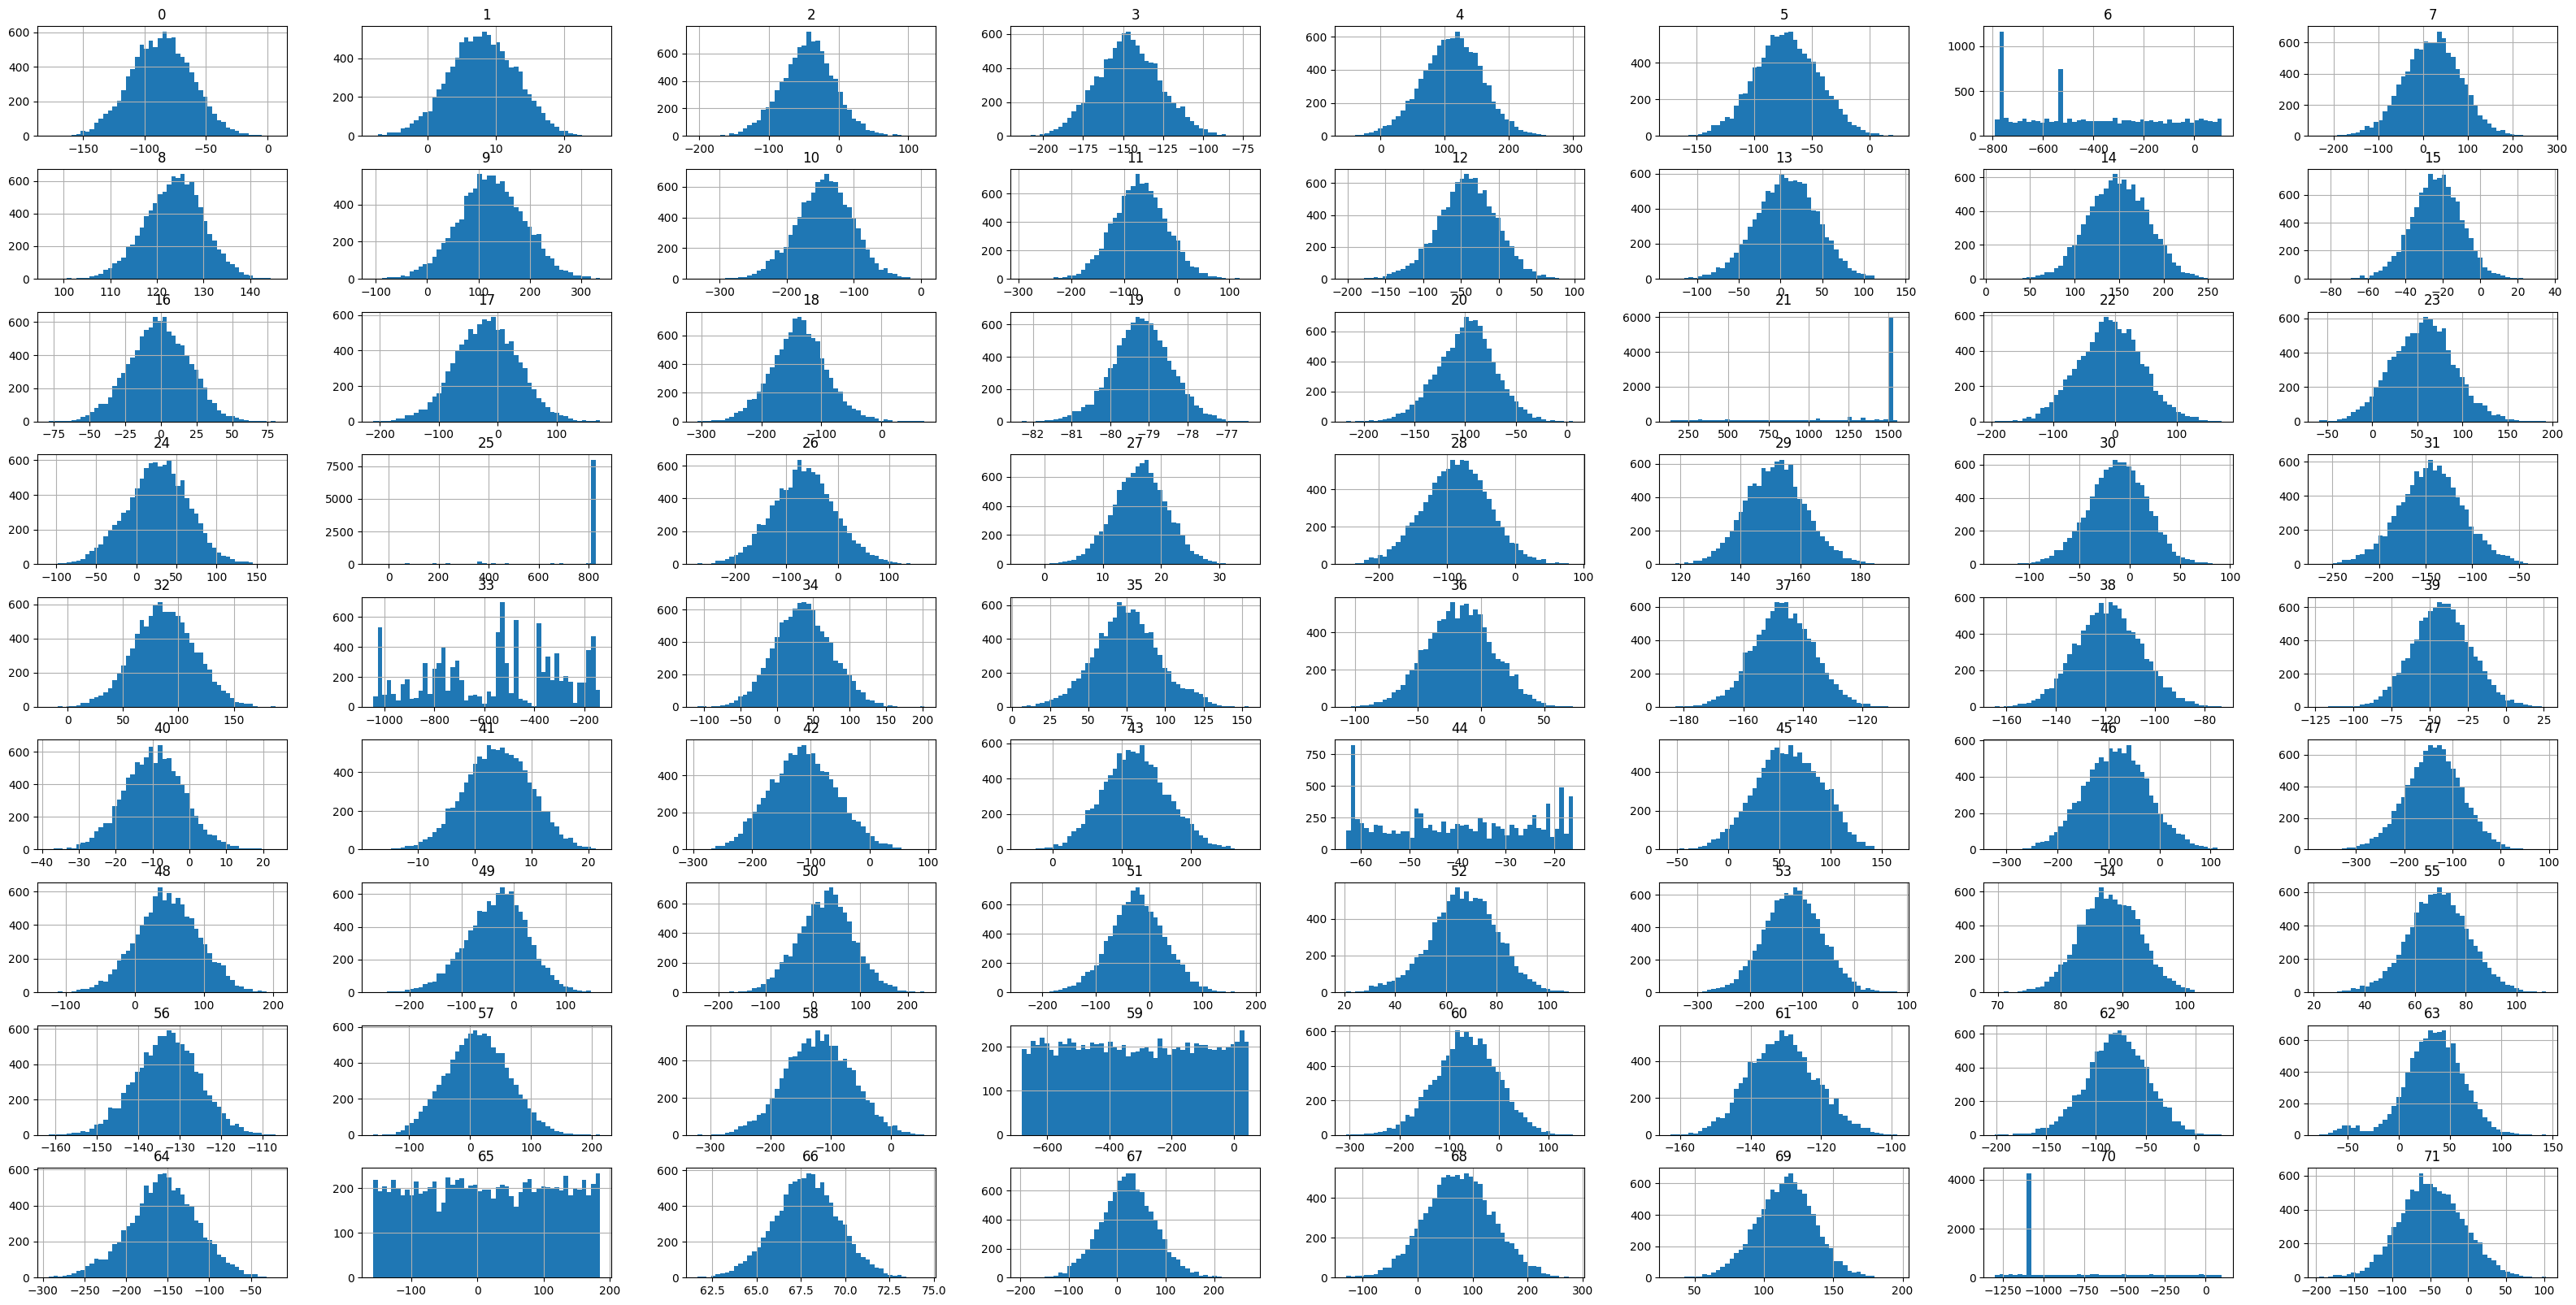

In [32]:
df_samples.hist(figsize=[40, 20], bins=50);

In [33]:
df_samples = df_train[:5000]

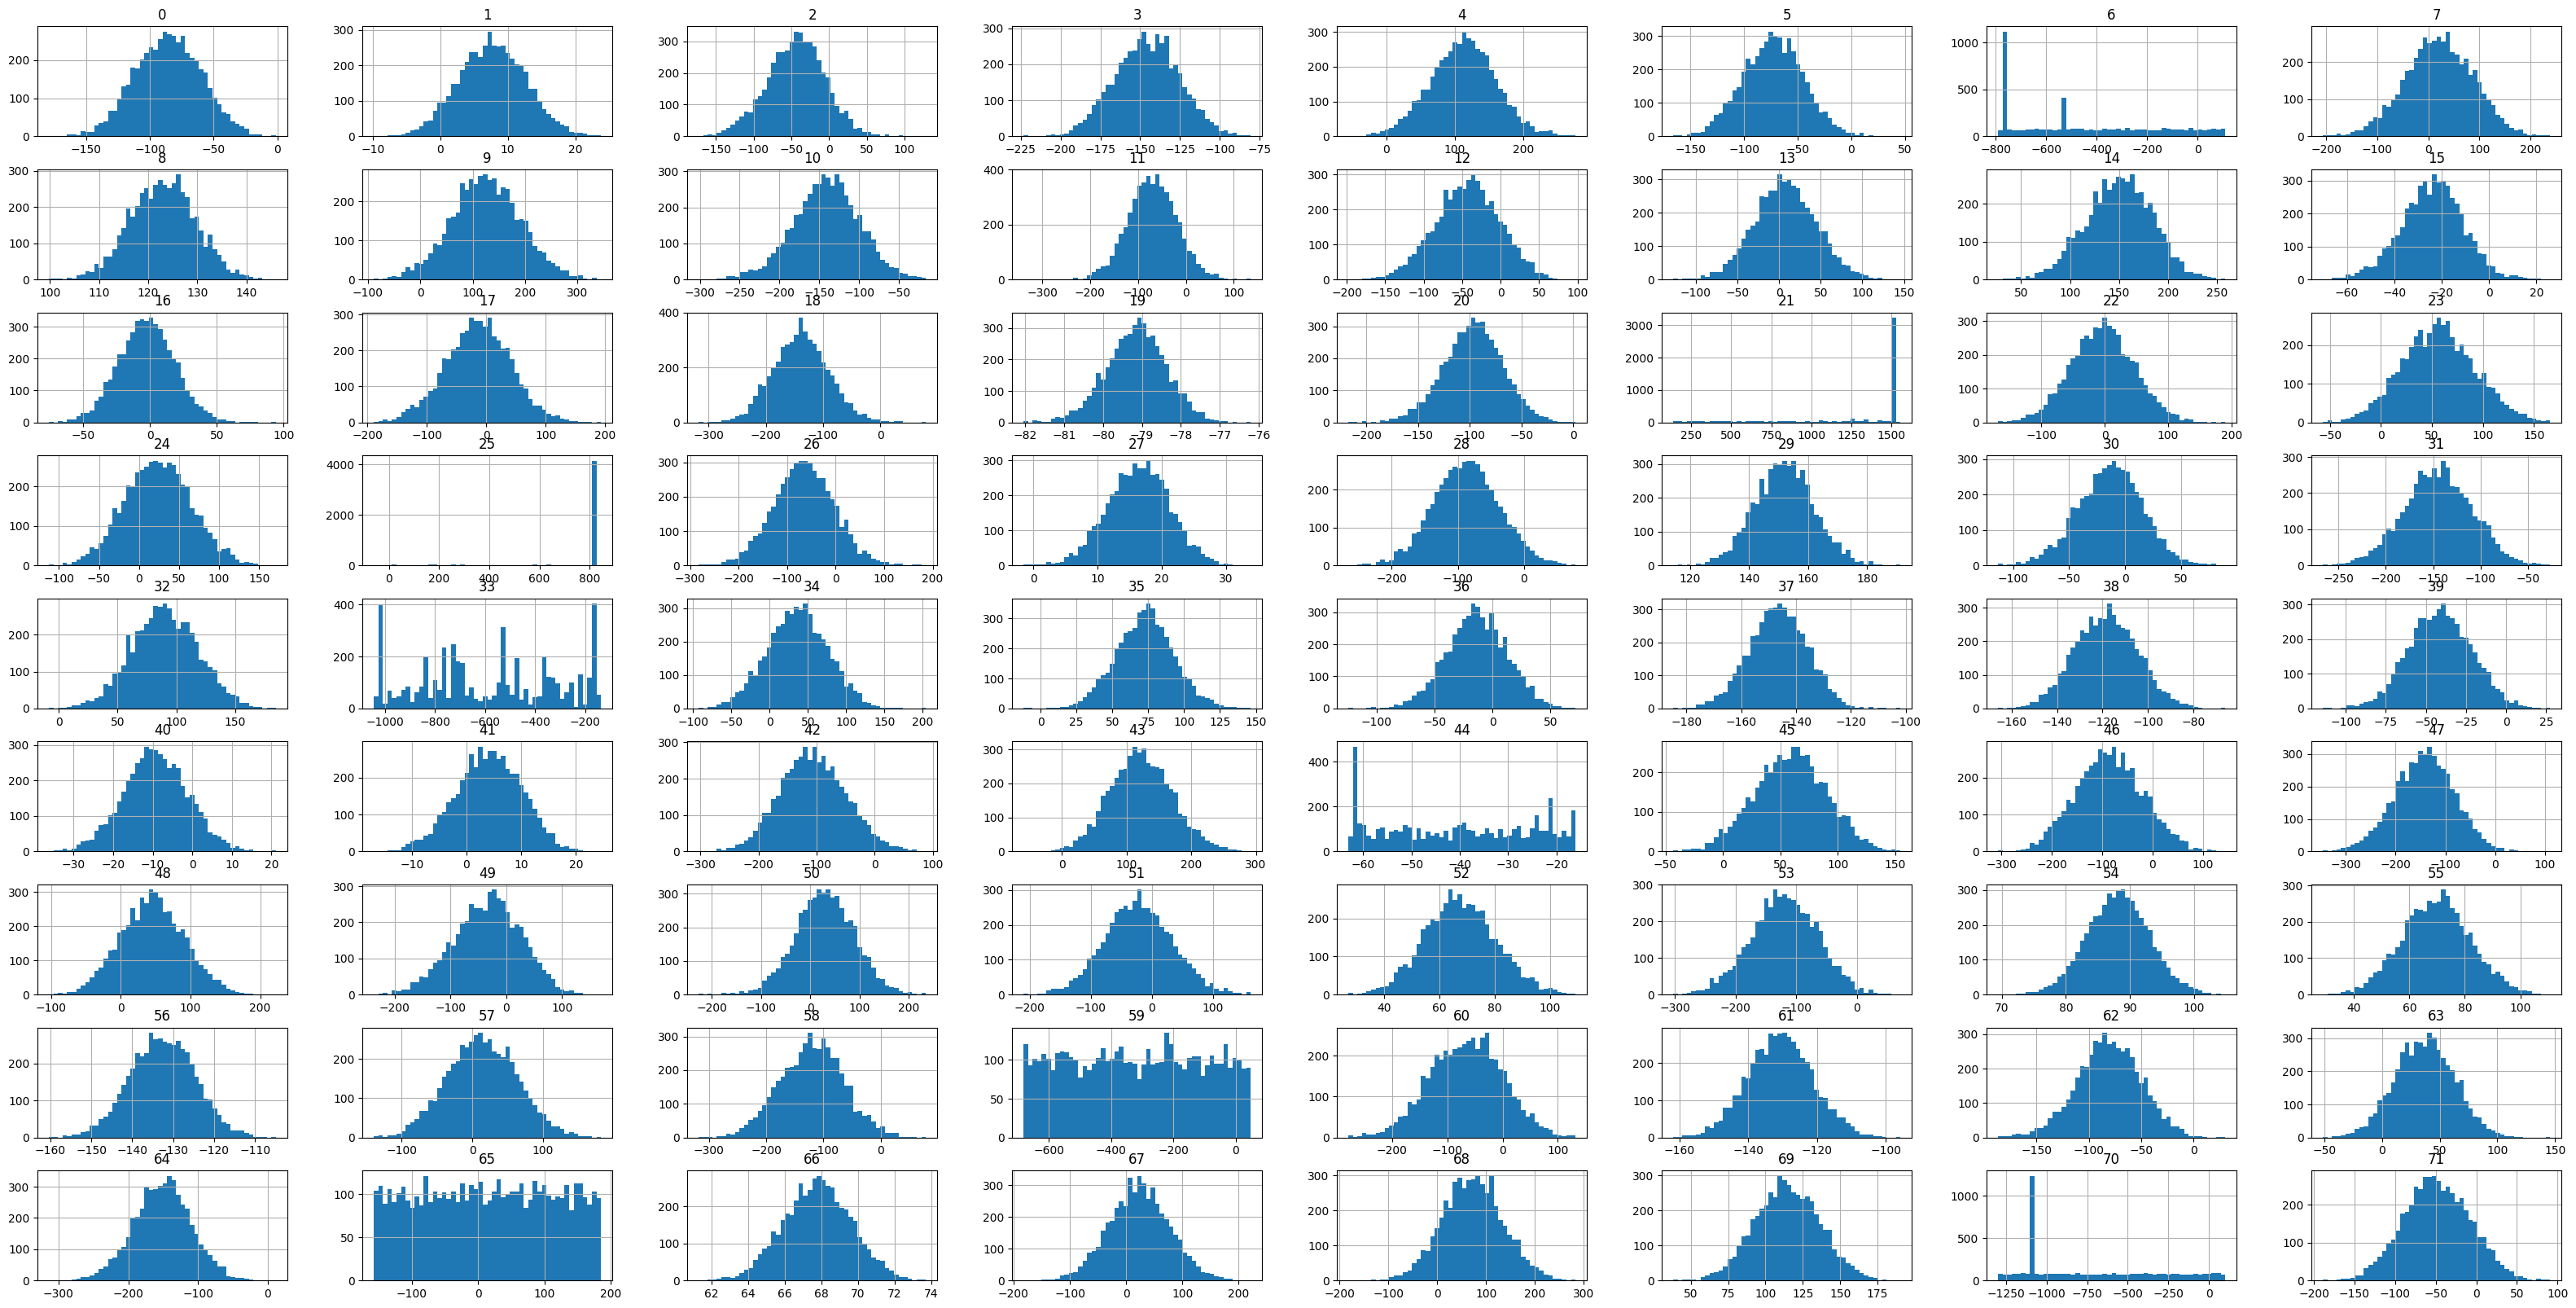

In [34]:
df_samples.hist(figsize=[40, 20], bins=50);

В `df_train` распределения выглядят аналогичным образом. Отметим, что в столбцах '6', '21', '25', '33', '44', '65', '70' распределения признаков значительно отличаются от нормальных.

### Оптимизация данных

Проведём несколько экспериментов, чтобы понять, как отразятся на метрике удаление отдельных признаков, а также различные варианты масштабирования признаков.

In [35]:
scaler_MM = MinMaxScaler()
df_base_MM = scaler_MM.fit_transform(df_base)
df_train_MM = scaler_MM.transform(df_train)

In [36]:
%%time
dims = df_base_MM.shape[1] #кол-во признаков
k = 5 #кол-во ближайших соседей
n_cells = 1000 #кол-во ячеек в индексе
nprobe = 10 #кол-во кластеров для поиска

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.train(np.ascontiguousarray(df_base_MM).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_MM).astype('float32'))
idx_l2.nprobe = nprobe
r, idx = idx_l2.search(np.ascontiguousarray(df_train_MM).astype('float32'), k)
accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'MinMaxScaler')

Кластеры: 1000, nprobe: 10, accuracy@5: 20.33 %
CPU times: user 3min 50s, sys: 3.3 s, total: 3min 53s
Wall time: 2min 21s


In [37]:
del df_base_MM
del df_train_MM

In [38]:
unnormal_columns = ['6', '21', '25', '33', '44', '65', '70']
df_base_drop = df_base.copy()
df_train_drop = df_train.copy()

for df in [df_base_drop, df_train_drop]:
  for column in unnormal_columns:
    df.drop(column, axis=1, inplace=True)

In [39]:
%%time
dims = df_base_drop.shape[1] #кол-во признаков
k = 5 #кол-во ближайших соседей
n_cells = 1000 #кол-во ячеек в индексе
nprobe = 10 #кол-во кластеров для поиска

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.train(np.ascontiguousarray(df_base_drop.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_drop.values).astype('float32'))
idx_l2.nprobe = nprobe
r, idx = idx_l2.search(np.ascontiguousarray(df_train_drop.values).astype('float32'), k)
accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'Drop Unnormal')

Кластеры: 1000, nprobe: 10, accuracy@5: 25.903 %
CPU times: user 3min 15s, sys: 1.38 s, total: 3min 16s
Wall time: 2min 1s


In [40]:
# important_columns = ['7', '17', '3', '28', '34', '4', '42',
#                      '27', '13', '49', '20', '10', '29', '41',
#                      '55', '62', '58', '24', '16']
important_columns = ['6', '70', '33', '27', '65', '21', '68',
                     '34', '31', '8', '42', '50', '43', '4',
                     '41', '62']
df_base_drop = df_base[important_columns]
df_train_drop = df_train[important_columns]

In [41]:
%%time
dims = df_base_drop.shape[1] #кол-во признаков
k = 5 #кол-во ближайших соседей
n_cells = 1000 #кол-во ячеек в индексе
nprobe = 10 #кол-во кластеров для поиска

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.train(np.ascontiguousarray(df_base_drop.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_drop.values).astype('float32'))
idx_l2.nprobe = nprobe
r, idx = idx_l2.search(np.ascontiguousarray(df_train_drop.values).astype('float32'), k)
accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'Drop Unimportant (Catboost-2)')

Кластеры: 1000, nprobe: 10, accuracy@5: 10.573 %
CPU times: user 1min, sys: 385 ms, total: 1min 1s
Wall time: 36.4 s


In [42]:
scaler_RS = RobustScaler()
df_base_RS = scaler_RS.fit_transform(df_base)
df_train_RS = scaler_RS.transform(df_train)

In [43]:
%%time
dims = df_base_RS.shape[1] #кол-во признаков
#base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
k = 5 #кол-во ближайших соседей
n_cells = 1000 #кол-во ячеек в индексе
nprobe = 10 #кол-во кластеров для поиска

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.train(np.ascontiguousarray(df_base_RS).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_RS).astype('float32'))
idx_l2.nprobe = nprobe
r, idx = idx_l2.search(np.ascontiguousarray(df_train_RS).astype('float32'), k)
accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'RobustScaler')

Кластеры: 1000, nprobe: 10, accuracy@5: 52.55 %
CPU times: user 3min 26s, sys: 1.51 s, total: 3min 28s
Wall time: 2min 5s


In [44]:
del df_base_RS
del df_train_RS

In [45]:
scaler_SS = StandardScaler()
df_base_SS = scaler_SS.fit_transform(df_base)
df_train_SS = scaler_SS.transform(df_train)
scaler_filename = '/content/drive/MyDrive/std_scale_1.bin'
dump(scaler_SS, scaler_filename, compress=True)

df_base_drop_SS = scaler_SS.fit_transform(df_base_drop)
df_train_drop_SS = scaler_SS.transform(df_train_drop)

In [46]:
del df_base_drop
del df_train_drop

In [47]:
%%time
dims = df_base_SS.shape[1] #кол-во признаков
k = 5 #кол-во ближайших соседей
n_cells = 1000 #кол-во ячеек в индексе
nprobe = 10 #кол-во кластеров для поиска

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.train(np.ascontiguousarray(df_base_SS).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_SS).astype('float32'))
idx_l2.nprobe = nprobe
r, idx = idx_l2.search(np.ascontiguousarray(df_train_SS).astype('float32'), k)
accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'StandardScaler')

Кластеры: 1000, nprobe: 10, accuracy@5: 63.748 %
CPU times: user 3min 39s, sys: 1.53 s, total: 3min 41s
Wall time: 2min 15s


In [48]:
%%time
dims = df_base_drop_SS.shape[1] #кол-во признаков
k = 5 #кол-во ближайших соседей
n_cells = 1000 #кол-во ячеек в индексе
nprobe = 10 #кол-во кластеров для поиска

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.train(np.ascontiguousarray(df_base_drop_SS).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_drop_SS).astype('float32'))
idx_l2.nprobe = nprobe
r, idx = idx_l2.search(np.ascontiguousarray(df_train_drop_SS).astype('float32'), k)
accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, \
                    'StandardScaler, Drop Unimportant')

Кластеры: 1000, nprobe: 10, accuracy@5: 27.923 %
CPU times: user 60 s, sys: 590 ms, total: 1min
Wall time: 38.5 s


In [49]:
del df_base_drop_SS
del df_train_drop_SS
# del df_base_SS
# del df_train_SS

### Промежуточные результаты - 2

In [50]:
my_metrics = pd.DataFrame(overall_scores)
my_metrics

,Кластеры,Поиск в соседних,Опции,accuracy@5
0,100,1,baseline,7.631
1,1000,1,search,4.369
2,1000,2,search,6.196
3,1000,10,search,11.190
4,500,1,search,5.194
5,500,2,search,7.368
6,500,10,search,12.288
7,200,1,search,6.552
8,200,2,search,8.980
9,200,10,search,13.260


Наилучшие показатели у данных, отмасштабированных с помощью StandardScaler. Будем работать с этими данными дальше.

Вообще такой большой прирост качества "из коробки" намекает, что работой с признаками можно ещё сильнее улучшить метрику.

## Ранжирование (IMPLEMENTED BUT NOT WORKING)

### Catboost в качестве ранжирующей модели

Соберём большее количество соседей. Для экономии времени была выбрана не самая оптимальная конфигурация.

In [51]:
# здесь подобрать оптимальные параметры для будущего использования

dims = df_base.shape[1] #кол-во признаков
k = 50 #кол-во ближайших соседей
n_cells = 200 #кол-во ячеек в индексе
nprobe = 20 #кол-во кластеров для поиска
index_filename = f'/content/drive/MyDrive/idx_l2_{n_cells}_{nprobe}.index'

Сохраним индекс на диске. В будущем можно будет им пользоваться, не проводя предварительные вычисления.

In [52]:
%%time
if not os.path.exists(index_filename):
  quantizer = faiss.IndexFlatL2(dims)
  idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
  idx_l2.train(np.ascontiguousarray(df_base_SS).astype('float32'))
  idx_l2.add(np.ascontiguousarray(df_base_SS).astype('float32'))
  idx_l2.nprobe = nprobe
  r, idx = idx_l2.search(np.ascontiguousarray(df_train_SS).astype('float32'), k)
  accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'StandardScaler, 50 Neighbours')
  faiss.write_index(idx_l2, index_filename)
else:
  idx_l2 = faiss.read_index(index_filename)

CPU times: user 254 ms, sys: 504 ms, total: 758 ms
Wall time: 9.52 s


In [53]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_train_SS).astype('float32'), 50)
accuracy_aggregator(targets, idx, base_index, n_cells, nprobe, 'StandardScaler, 50 Neighbours')

Кластеры: 200, nprobe: 20, accuracy@5: 75.136 %
CPU times: user 26min 30s, sys: 2.53 s, total: 26min 33s
Wall time: 16min 20s


In [54]:
my_metrics = pd.DataFrame(overall_scores)
my_metrics.tail(1)

,Кластеры,Поиск в соседних,Опции,accuracy@5
16,200,20,"StandardScaler, 50 Neighbours",75.136


In [55]:
len(idx)

100000

In [56]:
len(idx[0])

50

In [57]:
targets.head()

Id
0-query     675816-base
1-query     366656-base
2-query    1447819-base
3-query    1472602-base
4-query     717819-base
Name: Target, dtype: object

In [58]:
# формирование списка названия колонок для обучающего датафрейма
columns=df_base.columns.tolist()
all_columns = columns
new_columns = [f'{col}_search' for col in columns]
all_columns.extend(new_columns)
all_columns.extend(['is_neighbour'])

In [59]:
# Далее идет совершенно неправильный способ задания обучающего датафрейма.
# df_base_cat = pd.DataFrame(columns=all_columns)
# columns=df_base.columns.tolist()
# df_base_cat

In [60]:
# инициализация матриц для внесения сравниваемых признаков
np_base_SS = np.empty(72)
np_train_SS = np.empty(72)

results = []
base_names = []

In [61]:
%%time
sycle = 0
# Берём ограниченный объём данных.
for target, el in zip(targets.values.tolist()[:2000], idx.tolist()[:2000]):
  for r in el:
    #если делать так, всё очень медленно
    #df_base_cat.loc[sycle, columns] = df_base_SS[r]
    #df_base_cat.loc[sycle, new_columns] = df_train_SS[sycle]
    #df_base_cat.loc[sycle, 'result'] = base_index[r]

    if target == base_index[r]:
      #df_base_cat.loc[sycle, 'is_neighbour'] = 1
      results.append(1)
    else:
      #df_base_cat.loc[sycle, 'is_neighbour'] = 0
      results.append(0)

    np_base_SS = np.vstack([np_base_SS, df_base_SS[r]])
    np_train_SS = np.vstack([np_train_SS, df_train_SS[sycle]])
    base_names.append(base_index[r])
    sycle+=1

sycle

CPU times: user 20min 22s, sys: 14min 40s, total: 35min 2s
Wall time: 35min 5s


100000

In [62]:
sum(results)

1497

In [63]:
# соединяем матрицы, удаляем первую строку (возникла при инициализации)
cat_array = np.hstack([np_base_SS, np_train_SS])
cat_array = np.delete(cat_array, (0), axis=0)
cat_array.shape

(100000, 144)

In [64]:
# добаляем столбец с таргетом
cat_array = np.insert (cat_array, 144, results, axis=1)

In [65]:
# матрица становится датафреймом
df_base_cat = pd.DataFrame(data=cat_array, columns=all_columns, index=base_names)
df_base_cat.shape

(100000, 145)

In [66]:
# df_base_cat['result'] = base_names
# df_base_cat = df_base_cat.set_index('result')

In [67]:
# df_base_cat.shape

In [68]:
df_base_cat[df_base_cat['is_neighbour']==1].sample()

,0,1,2,3,4,5,6,7,8,9,...,63_search,64_search,65_search,66_search,67_search,68_search,69_search,70_search,71_search,is_neighbour
9331-base,1.803287,0.990929,-0.205005,-1.534359,0.131804,0.275746,-1.352459,1.549478,-1.114749,-1.484287,...,0.162973,0.064828,0.162422,0.006194,-0.061588,0.215724,-0.855546,0.89324,1.729637,1.0


In [69]:
# Очень мало целевого признака
df_base_cat['is_neighbour'].sum()/df_base_cat.shape[0]

0.01497

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    df_base_cat.drop(['is_neighbour'] , axis=1),
    df_base_cat['is_neighbour'],
    test_size=0.25,
    random_state=2007,
    stratify=df_base_cat['is_neighbour']
    )

In [71]:
X_train.sample()

,0,1,2,3,4,5,6,7,8,9,...,62_search,63_search,64_search,65_search,66_search,67_search,68_search,69_search,70_search,71_search
1510475-base,-1.188506,-1.960247,0.768775,-1.051757,-1.570234,0.296086,-1.030584,2.886694,1.717281,-0.195111,...,-1.102213,0.494324,-0.567354,-1.34687,-0.854797,0.329056,-0.435161,-0.275496,-0.713847,-0.522641


In [72]:
cat_features = []

In [73]:
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )

In [74]:
test_data = Pool(data=X_test,
                  label=y_test,
                  cat_features=cat_features
                 )

In [75]:
params = {'cat_features': cat_features,
          'eval_metric': 'AUC',
          'loss_function': 'Logloss',
          #'learning_rate': 0.01,
          'random_seed': 2007,
          'verbose':100
          }

In [76]:
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=True,
    verbose=False,
    #early_stopping_rounds=200
)

Training on fold [0/5]

bestTest = 0.6626815256
bestIteration = 406

Training on fold [1/5]

bestTest = 0.6353468086
bestIteration = 211

Training on fold [2/5]

bestTest = 0.6429133296
bestIteration = 371

Training on fold [3/5]

bestTest = 0.6346896906
bestIteration = 270

Training on fold [4/5]

bestTest = 0.6356305898
bestIteration = 329



In [77]:
model = CatBoostClassifier(**params)

In [78]:
model.fit(train_data)

Learning rate set to 0.065101
0:	total: 98.5ms	remaining: 1m 38s
100:	total: 9.71s	remaining: 1m 26s
200:	total: 17.5s	remaining: 1m 9s
300:	total: 26.9s	remaining: 1m 2s
400:	total: 34.1s	remaining: 51s
500:	total: 43.4s	remaining: 43.2s
600:	total: 52s	remaining: 34.5s
700:	total: 60s	remaining: 25.6s
800:	total: 1m 9s	remaining: 17.3s
900:	total: 1m 16s	remaining: 8.45s
999:	total: 1m 26s	remaining: 0us


In [79]:
# может быть это будет полезно для оптимизации поиска.
# проверено. В первом случае помогло, во втором - наоборот
model.get_feature_importance(prettified=True).head(20)

,Feature Id,Importances
0,6,3.118518
1,70,3.052050
2,33,2.073040
3,27,1.602399
4,65,1.535582
5,21,1.233081
6,68,1.228448
7,34_search,1.209491
8,31,1.206455
9,8,1.072907


In [80]:
# Сохраним модель для будущего использования
model_filename = f'/content/drive/MyDrive/cbm_big.cbm'
model.save_model(model_filename,
           format="cbm",
           export_parameters=None,
           pool=None)

In [81]:
y_pr = model.predict_proba(test_data)[:, 1]
#np.argsort(y_pr)

In [82]:
X_test['is_neighbour'] = y_test
X_test['is_neighbour_proba'] = y_pr
roc_auc_score(X_test['is_neighbour'],X_test['is_neighbour_proba'])

0.5993420935483604

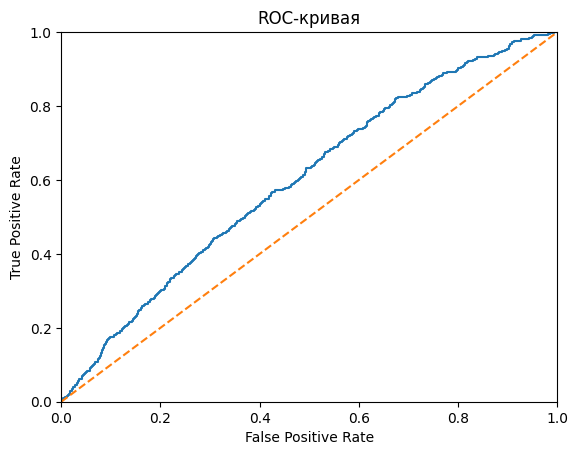

In [83]:
fpr, tpr, thresholds = roc_curve(X_test['is_neighbour'], X_test['is_neighbour_proba'])
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Модель требует дополнительной настройки и в данном виде неприменима для улучшения метрики.

### Промежуточные результаты - 3

In [84]:
my_metrics = pd.DataFrame(overall_scores)
my_metrics

,Кластеры,Поиск в соседних,Опции,accuracy@5
0,100,1,baseline,7.631
1,1000,1,search,4.369
2,1000,2,search,6.196
3,1000,10,search,11.190
4,500,1,search,5.194
5,500,2,search,7.368
6,500,10,search,12.288
7,200,1,search,6.552
8,200,2,search,8.980
9,200,10,search,13.260


Как показывает тестирование, модель в состоянии указать на наиболее важные признаки, которым можно будет уделять дополнительное внимание.

## Решение задачи

Загрузим сохранённые ранее индекс, скейлер и модель и проведём поиск 5 ближайших соседей для всех товаров из `validation.csv`.

In [85]:
idx_l2 = faiss.read_index('/content/drive/MyDrive/idx_l2_200_20.index')
nprobe = idx_l2.nprobe

In [86]:
# ответы у нас уже есть
answers = df_validation_answer.squeeze()
# не забываем масштабирование
scaler_SS=load('/content/drive/MyDrive/std_scale_1.bin')
df_validation_SS = scaler_SS.transform(df_validation)

In [101]:
# загрузка модели CatBoostClassifier
model = CatBoostClassifier()
model.load_model('/content/drive/MyDrive/cbm_big.cbm')
print(model.get_params())

{'eval_metric': 'AUC', 'random_seed': 2007, 'loss_function': 'Logloss', 'verbose': 100}


Найдём 20 ближайших соседей для валидационной выборки. Посчитаем сначала метрику без ранжирующей модели.

In [87]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_validation_SS).astype('float32'), 20)
idx_cat = idx # для ранжирующей модели возьмем всех найденных 20 соседей
idx = np.delete(idx, list(range(5, 20)), 1)
idx.shape

CPU times: user 26min 37s, sys: 2.14 s, total: 26min 39s
Wall time: 18min 3s


(100000, 5)

In [88]:
accuracy_aggregator(
    answers, idx, base_index, 200, nprobe, 'Validation, 5 Neigbours')

Кластеры: 200, nprobe: 20, accuracy@5: 64.801 %


In [89]:
accuracy_aggregator(
    answers, idx_cat, base_index, 200, nprobe, 'Validation, 20 Neigbours')

Кластеры: 200, nprobe: 20, accuracy@5: 71.656 %


In [91]:
idx_cat.shape

(100000, 20)

Теперь с помощью ранжирующей модели выберем из 20 соседей лучших 5 по мнению модели. Посчитаем метрику.

In [92]:
# подготовка к инициализации датафрейма df_base_cat,
# который подаётся на вход модели Catboost
columns=df_base.columns.tolist()
all_columns = columns
new_columns = [f'{col}_search' for col in columns]
all_columns.extend(new_columns)
df_base_cat = pd.DataFrame(columns=all_columns)
columns=df_base.columns.tolist()
idx_cat_cut = np.empty(5, dtype=int)

In [93]:
# здесь опять медленный способ работы, нужно исправить.
# опять работа на ограниченном наборе данных
for step in range(20000):
  df_base_cat = pd.DataFrame(columns=all_columns)
  cycle = 0
  for el in idx_cat[step]:
    df_base_cat.loc[cycle, columns] = df_base_SS[el]
    df_base_cat.loc[cycle, new_columns] = df_validation_SS[step]
    cycle += 1
  z_pr = model.predict_proba(df_base_cat)[:, 1]
  idx_cat_cut = np.vstack([idx_cat_cut, np.delete(idx_cat[step], np.argsort(z_pr)[:15], 0)])

In [94]:
# удаление лишней первой строки
idx_cat_cut = np.delete(idx_cat_cut, 0, axis=0)

In [95]:
idx_cat_cut.shape

(20000, 5)

In [99]:
accuracy_aggregator(
    answers[:20000], idx_cat_cut, base_index, 200, nprobe, 'Validation, 5 Neigbours, CatBoost')

Кластеры: 200, nprobe: 20, accuracy@5: 27.625 %


In [100]:
my_metrics = pd.DataFrame(overall_scores)
my_metrics.tail(3)

,Кластеры,Поиск в соседних,Опции,accuracy@5
17,200,20,"Validation, 5 Neigbours",64.801
18,200,20,"Validation, 20 Neigbours",71.656
19,200,20,"Validation, 5 Neigbours, CatBoost",27.625


## Выводы

В проекте решалась **задача разработки алгоритма, который для всех товаров из `validation.csv` предложит несколько вариантов наиболее похожих товаров из `base.csv`**.

При этом:
- `base.csv` - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- `validation.csv` - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

Для подбора оптимальных параметров приближенного поиска использовался обучающий датасет `target.csv`. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …), вектор признаков и id товара из base.csv, который максимально похож на него (по мнению экспертов).

- При решении задачи была использована библиотека для приближённого поиска ближайших соседей `FAISS`.

- Проведён исследовательский анализ данных. В целях повышения метрики произведено масштабирование признаков с использованием `StandardScaler`.

- Создан, обучен и сохранён на диск индекс для `FAISS` с оптимальными в рамках данного исследования параметрами.

- В качестве демонстрации подхода обучена ранжирующая модель CatBoost. В дальнейшем модель позволит дополнительно оптимизировать поиск, а также выделить наиболее значимые признаки.

- Время поиска 5 ближайших соседей для датасета `validation.csv` на этом индексе составило около **15 минут** (Colab, без подписки).

- Качество предложенного алгоритма по метрике `accuracy@5` для датасета `validation.csv` составило **64,8%** (без применения ранжирующей модели).

- Сохранённые индекс и модель позволяют реализовать развёртывание решения в виде микросервиса.


### Что нужно улучшить

- Для выбора оптимального индекса надо оценить время работы для каждого из них
- Дальнейшая работа с признаками должна повысить метрику
- От ранжирующей модели нужно получить большее качество, после этого её нужно применять для отбора более качественных соседей (если это будет оправдано с точки зрения производительности)
- Полноценно реализовать решение в качестве микросервиса